<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/ae_fashion_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Autoencoder (using MLP and CNN) for fashion MNIST
# Based on 
# https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb

In [0]:
# Standard Python libraries
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

import sklearn

import seaborn as sns;
sns.set(style="ticks", color_codes=True)

import pandas as pd
pd.set_option('precision', 2) # 2 decimal places
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 100) # wide windows


In [7]:
# Tensorflow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras

print("tf version {}".format(tf.__version__))
if tf.test.is_gpu_available():
    print(tf.test.gpu_device_name())
else:
    print("TF cannot find GPU")

tf version 2.0.0-beta1
/device:GPU:0


In [2]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))


def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        


4423680/4422102 [==============================] - 0s 0us/step


W0824 17:08:42.652516 140632291149696 deprecation.py:323] From /tensorflow-2.0.0b1/python3.6/tensorflow/python/keras/backend.py:4149: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 6s 102us/sample - loss: 0.3386 - rounded_accuracy: 0.8866 - val_loss: 0.3154 - val_rounded_accuracy: 0.9119
Epoch 2/5
55000/55000 [==============================] - 4s 78us/sample - loss: 0.3055 - rounded_accuracy: 0.9154 - val_loss: 0.3030 - val_rounded_accuracy: 0.9200
Epoch 3/5
55000/55000 [==============================] - 4s 77us/sample - loss: 0.2986 - rounded_accuracy: 0.9214 - val_loss: 0.2981 - val_rounded_accuracy: 0.9250
Epoch 4/5
55000/55000 [==============================] - 4s 77us/sample - loss: 0.2946 - rounded_accuracy: 0.9251 - val_loss: 0.2938 - val_rounded_accuracy: 0.9284
Epoch 5/5
55000/55000 [==============================] - 4s 78us/sample - loss: 0.2921 - rounded_accuracy: 0.9273 - val_loss: 0.2922 - val_rounded_accuracy: 0.9302


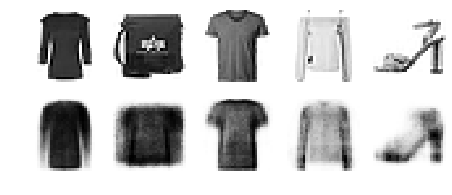

In [3]:
# MLP
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=5,
                         validation_data=[X_valid, X_valid])

show_reconstructions(stacked_ae)
#save_fig("ae-mlp-fashion-recon.pdf")
plt.show()

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 10s 179us/sample - loss: 0.3017 - rounded_accuracy: 0.9185 - val_loss: 0.2840 - val_rounded_accuracy: 0.9308
Epoch 2/5
55000/55000 [==============================] - 6s 116us/sample - loss: 0.2756 - rounded_accuracy: 0.9412 - val_loss: 0.2739 - val_rounded_accuracy: 0.9449
Epoch 3/5
55000/55000 [==============================] - 6s 115us/sample - loss: 0.2709 - rounded_accuracy: 0.9459 - val_loss: 0.2721 - val_rounded_accuracy: 0.9448
Epoch 4/5
55000/55000 [==============================] - 6s 116us/sample - loss: 0.2682 - rounded_accuracy: 0.9488 - val_loss: 0.2687 - val_rounded_accuracy: 0.9485
Epoch 5/5
55000/55000 [==============================] - 6s 116us/sample - loss: 0.2665 - rounded_accuracy: 0.9506 - val_loss: 0.2670 - val_rounded_accuracy: 0.9514


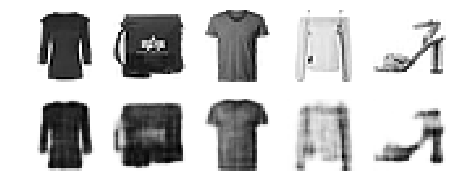

In [4]:
# CNN

tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=[X_valid, X_valid])

show_reconstructions(conv_ae)
#save_fig("ae-cnn-fashion-recon.pdf")
plt.show()

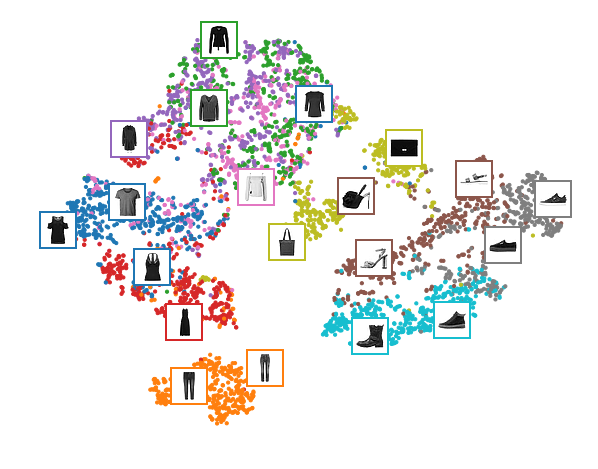

In [0]:
# Visualize 2d manifold from MLP encodings using tSNE

from sklearn.manifold import TSNE
import matplotlib

np.random.seed(42)

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = matplotlib.offsetbox.AnnotationBbox(
            matplotlib.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
#save_fig("ae-mlp-fashion-tsne.pdf")
plt.show()